# t-SNE and PCA dimensionality reduction and data visualization approach

In [1]:
%matplotlib inline
import os
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import numpy as np
from glob import glob
import matplotlib.cm as cm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [2]:
BASE_DATA_FOLDER = "/root/workspace/data/ctb/COVID-19-X/COVID-Net-Pytorch/dataset/ttv"
TRAin_DATA_FOLDER = os.path.join(BASE_DATA_FOLDER, "train")

In [3]:
def visualize_scatter_with_images(X_2d_data, images, figsize=(25,25), image_zoom=1):
    fig, ax = plt.subplots(figsize=figsize)
    artists = []
    for xy, i in zip(X_2d_data, images):
        x0, y0 = xy
        img = OffsetImage(i, zoom=image_zoom)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_2d_data)
    ax.autoscale()
    plt.show()

def visualize_scatter(data_2d, label_ids, figsize=(20,20)):
    plt.figure(figsize=figsize)
    plt.grid()
    
    nb_classes = len(np.unique(label_ids))
    
    for label_id in np.unique(label_ids):
        plt.scatter(data_2d[np.where(label_ids == label_id), 0],
                    data_2d[np.where(label_ids == label_id), 1],
                    marker='o',
                    color= plt.cm.Set1(label_id / float(nb_classes)),
                    linewidth= 1,
                    alpha=0.8,
                    label=id_to_label_dict[label_id])
    plt.legend(loc='best')
    # plt.show()




In [4]:
images = []
labels = []

for class_folder_name in os.listdir(TRAin_DATA_FOLDER):
    class_folder_path = os.path.join(TRAin_DATA_FOLDER, class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpeg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
    for image_path in glob(os.path.join(class_folder_path, "*.jpg")):
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        
        image = image.flatten()
        
        images.append(image)
        labels.append(class_folder_name)
        
images = np.array(images)
labels = np.array(labels)

In [6]:
label_to_id_dict = {v:i for i,v in enumerate(np.unique(labels))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[x] for x in labels])

images_scaled = StandardScaler().fit_transform(images)

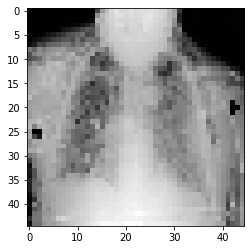

In [7]:
plt.imshow(np.reshape(images[15], (45,45)), cmap="gray")

In [8]:
pca = PCA(n_components=180)
pca_result = pca.fit_transform(images_scaled)
pca_result.shape

(18317, 180)

# t-SNE

In [9]:
tsne = TSNE(n_components=2, perplexity=10.0)
tsne_result = tsne.fit_transform(pca_result)
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)
print (tsne_result_scaled.shape)
print(label_ids)
# visualize_scatter(tsne_result_scaled, label_ids)


/root/miniconda3/envs/ct/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/root/miniconda3/envs/ct/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(18317, 2)
[2 2 2 ... 1 1 1]


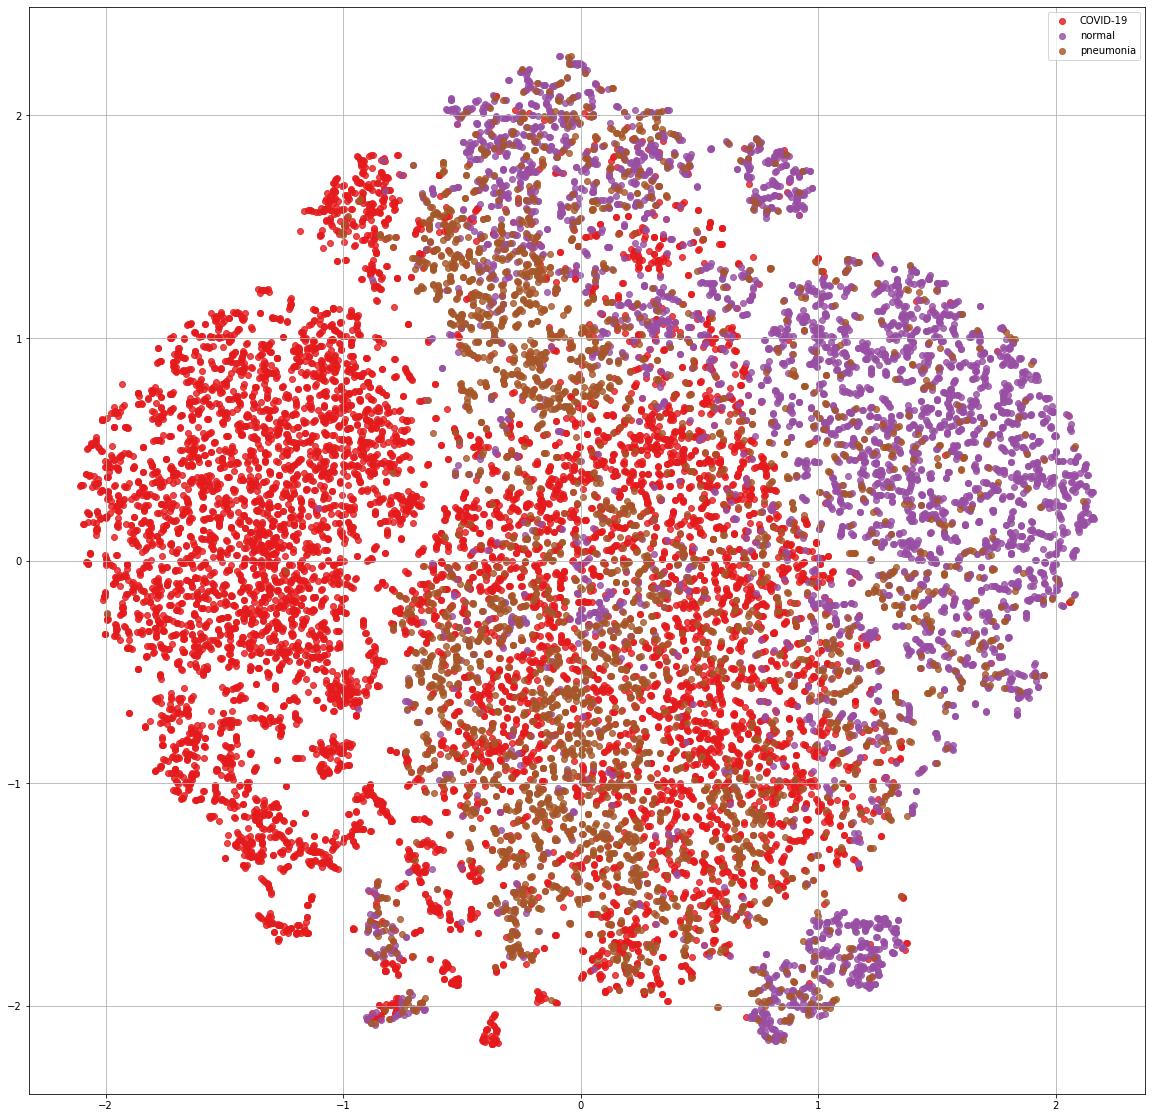

In [10]:
# print(tsne_result_scaled)
visualize_scatter(tsne_result_scaled, label_ids)


In [11]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import f1_score

clusterer = KMeans(n_clusters=3)
preds = clusterer.fit_predict(tsne_result_scaled)
centers = clusterer.cluster_centers_
score = silhouette_score(tsne_result_scaled, preds)
print ("Sillouette Score", score)

from sklearn.mixture import GaussianMixture
gm = GaussianMixture(n_components=3, random_state=0).fit(tsne_result_scaled)
preds = gm.predict(tsne_result_scaled)
score = silhouette_score(tsne_result_scaled, preds)
print ("Sillouette Score", score)

Sillouette Score 0.3827837
Sillouette Score 0.3775792


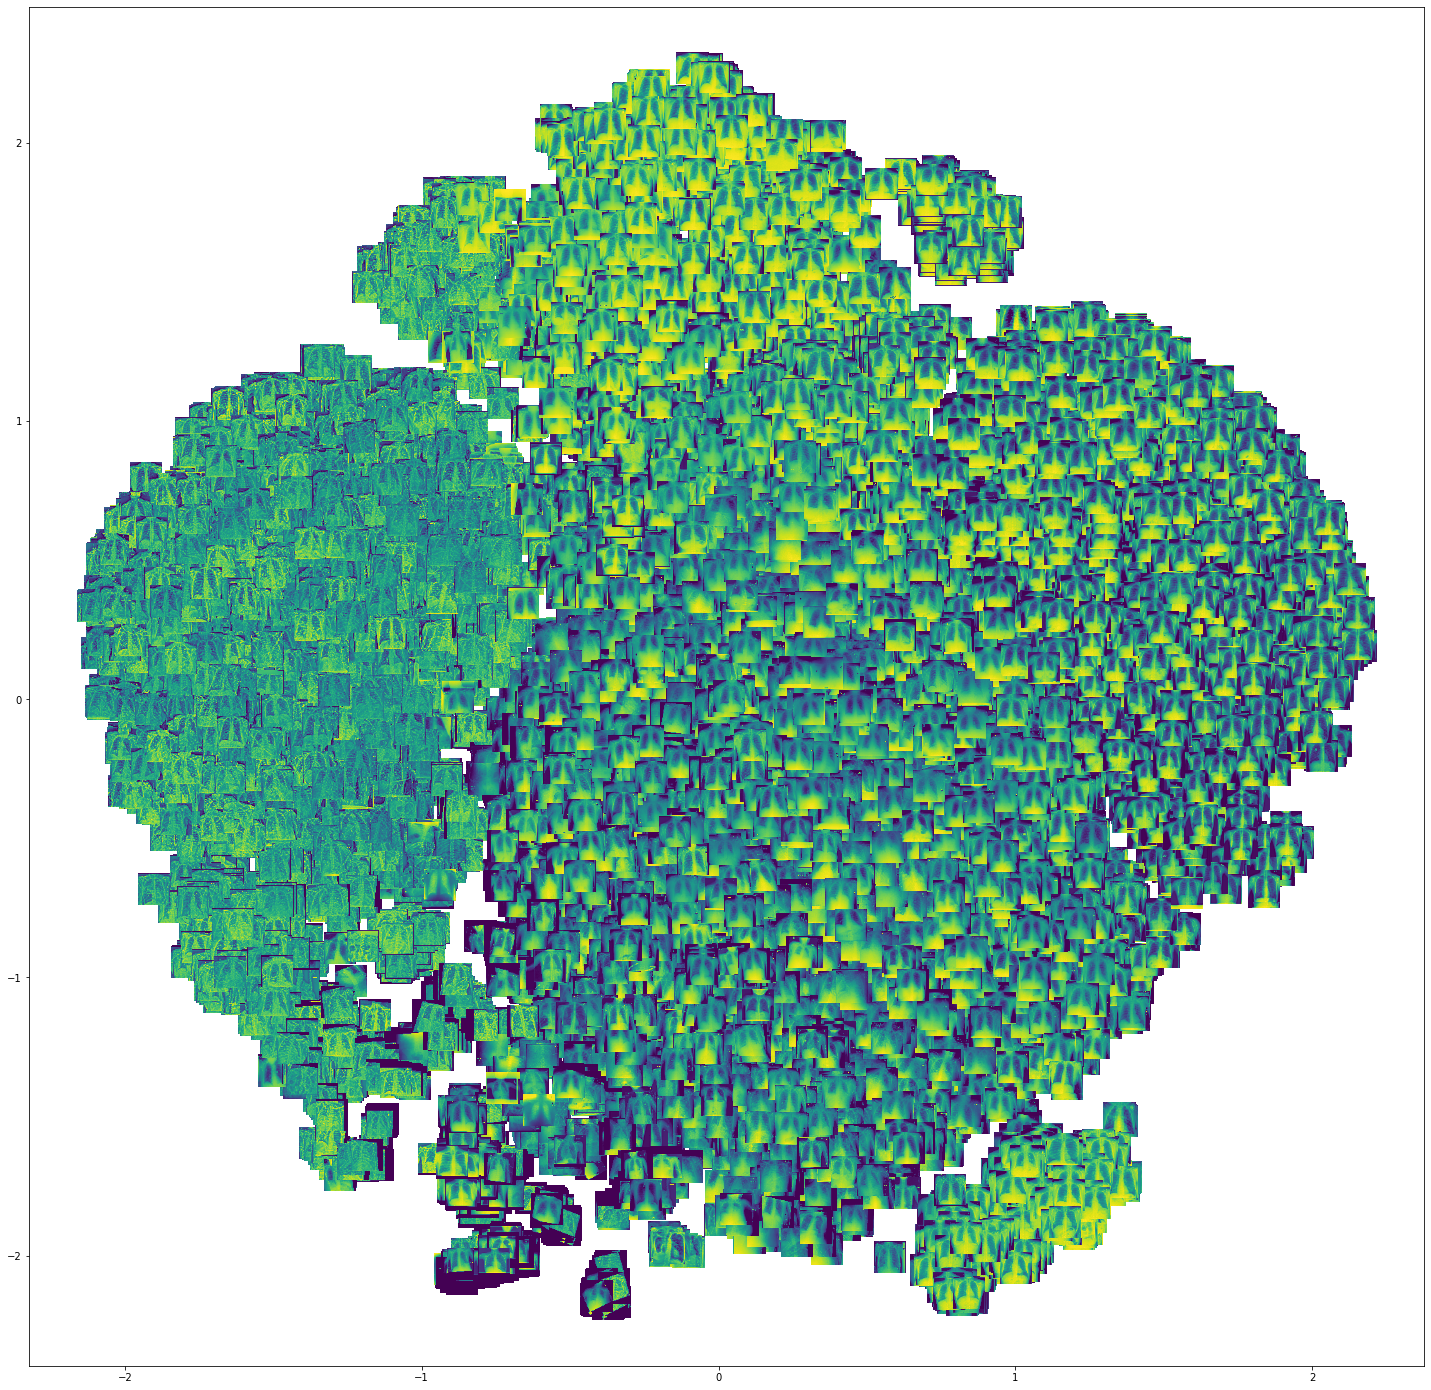

In [12]:
visualize_scatter_with_images(tsne_result_scaled, images = [np.reshape(i, (45,45)) for i in images], image_zoom=0.7)